In [1]:
## SIREN (Sitzman et al. 2020) x deepOnet 
#https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from jaxtyping import Array, Float
from typing import Union, Sequence, Callable
import optax


/nix/store/9252gsdx08cpwxrhsmyxh6lrjhi7nlg2-python3-3.12.10-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# The dataset is curtesy of the DeepXDE library (Lu et al.), was used in a
# tutorial similar in scope to this notebook
# https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html
# Download from a github repository of ETH Zurich's course on "Deep Learning in
# Scienfitic Computing"
# !wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
# !wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz


In [4]:
dataset_train = jnp.load("antiderivative_aligned_train.npz", allow_pickle=True)
branch_inputs_train = dataset_train["X"][0]
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"]

print(f"{branch_inputs_train.shape=} {trunk_inputs_train.shape=} {outputs_train.shape=}")

dataset_test = jnp.load("antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = dataset_test["X"][0]
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"]

print(f"{branch_inputs_test.shape=} {trunk_inputs_test.shape=} {outputs_test.shape=}")



branch_inputs_train.shape=(150, 100) trunk_inputs_train.shape=(100, 1) outputs_train.shape=(150, 100)
branch_inputs_test.shape=(1000, 100) trunk_inputs_test.shape=(100, 1) outputs_test.shape=(1000, 100)


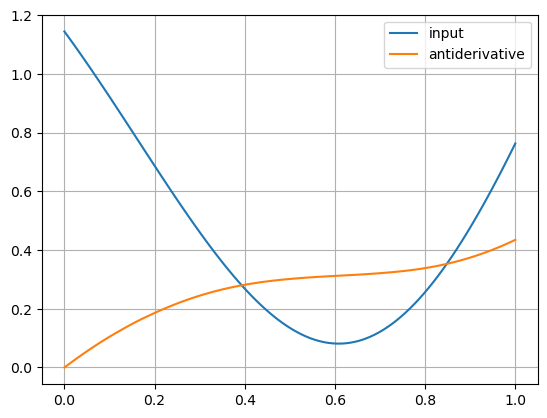

In [5]:
plt.plot(
    trunk_inputs_train[:, 0],
    branch_inputs_train[2, :],
    label="input",
)
plt.plot(
    trunk_inputs_train[:, 0],
    outputs_train[2, :],
    label="antiderivative",
)
plt.legend()
plt.grid()

In [6]:
class SirenLayer(eqx.Module):
    weight: Float[Array, "out_size in_size"]
    bias: Float[Array, "out_size"]

    def __init__(self, in_size: int, out_size: int, w0: float, is_first_layer: bool, *, key: Array):
        w_key, b_key = jr.split(key)
        lim = 1/in_size if is_first_layer == 0 else jnp.sqrt(6. /in_size) / w0
        self.weight =  jr.uniform(
            key=w_key,
            shape=(out_size, in_size),
            minval=-lim,
            maxval=lim
        ) 

        bias_factor = jnp.pi / jnp.sqrt(
            jnp.sum(jnp.square(self.weight), axis=1))  
        
        self.bias = jr.uniform(
            key=b_key,
            shape=(out_size,),
            minval=-1,
            maxval=1
        ) * bias_factor

    def __call__(self, x: Float[Array, "in_size"]) -> Float[Array, "out_size"]:
        return self.weight @ x + self.bias


        
class SIREN(eqx.Module):
    layers: Sequence[SirenLayer]
    w0:     Float[Array, ""]  
    
    def __init__(self, in_size, out_size, width_size, depth, w0, *, key):
        widths = [in_size] + [width_size]* (depth - 1) + [out_size]
        keys = jr.split(key, len(widths))
        
        self.layers = tuple(
            SirenLayer(widths[i], widths[i+1], w0, i, key= keys[i])
            for i in range(len(widths)-1)
        )
        self.w0 = jnp.array(w0)
        
    def __call__(self, x: Float[Array, "in_size"]) -> Float[Array, "out_size"]:
        h = x
        for layer in self.layers[:-1]:
            h = jnp.sin( self.w0 * layer(h))
        return self.layers[-1](h).squeeze()



class DeepONet1d(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array
    w0:     Float[Array, ""]  

    def __init__(
        self,
        in_size_branch,
        width_size,
        depth,
        interact_size,
        w0,
        *,
        key,
    ):
        """
        For simplicity, branch and trunk MLP are configured similarly
        """
        b_key, t_key = jr.split(key)
        self.branch_net = SIREN(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            w0=w0,
            key=b_key,
        )
        self.trunk_net =SIREN(
            in_size=1,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            w0=w0,
            key=t_key,
        )
        self.bias = jnp.zeros((1,))
        self.w0 = jnp.array(w0)

    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """
        branch_out = self.branch_net(x_branch)
        trunk_out = jnp.sin(self.w0* self.trunk_net(x_trunk))
        inner_product = jnp.sum(branch_out * trunk_out, keepdims=True)

        return (inner_product + self.bias).squeeze()
        
        
        

    

In [7]:
antiderivative_operator = DeepONet1d(
    in_size_branch=100,
    width_size=40,
    depth=2,
    interact_size=40,
    w0=1,
    key=jr.PRNGKey(0),
)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(
    eqx.filter(antiderivative_operator, eqx.is_array)
)

def loss_fn(model):
    # Full batch training

    # Vectorize over both the batches/samples and the query points
    predictions = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0),
        ),
        in_axes=(0, None)
    )(branch_inputs_train, trunk_inputs_train)

    mse = jnp.mean(jnp.square(predictions - outputs_train))
    return mse



    
    

@eqx.filter_jit
def update_fn(model, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

loss_history = []
validation_history = []
for _ in tqdm(range(10_000)):
    antiderivative_operator, opt_state, loss = update_fn(
        antiderivative_operator, opt_state
    )
    loss_history.append(loss)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 814.00it/s]


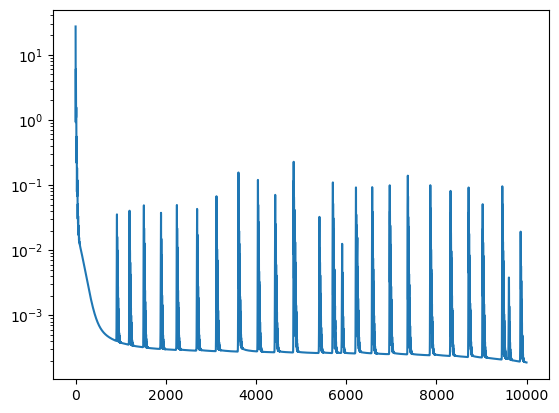

In [8]:
plt.semilogy(loss_history)

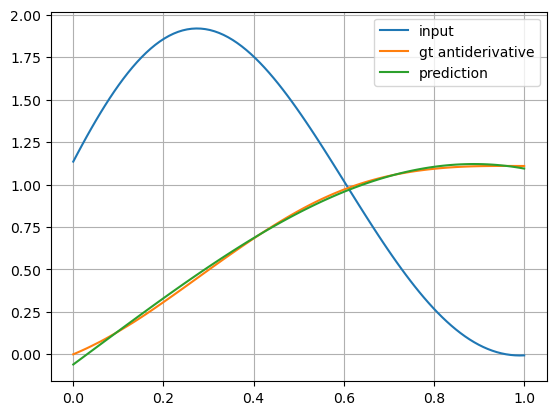

In [9]:
plt.plot(
    trunk_inputs_test[:, 0],
    branch_inputs_test[0, :],
    label="input",
)
plt.plot(
    trunk_inputs_test[:, 0],
    outputs_test[0, :],
    label="gt antiderivative",
)
plt.plot(
    trunk_inputs_test[:, 0],
    jax.vmap(
        antiderivative_operator,
        in_axes=(None, 0)
    )(branch_inputs_test[0, :], trunk_inputs_test),
    label="prediction",
)
plt.legend()
plt.grid()

In [10]:
predictions_test = jax.vmap(jax.vmap(antiderivative_operator, in_axes=(None, 0)), in_axes=(0, None,) )(branch_inputs_test, trunk_inputs_test)

def normalized_l2_error(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

test_errors = jax.vmap(normalized_l2_error)(predictions_test, outputs_test)
mean_test_error = jnp.mean(test_errors)
std_test_error = jnp.std(test_errors)
mean_test_error, std_test_error

(Array(0.05043015, dtype=float32), Array(0.0605991, dtype=float32))